Loading and preparing the CIFAR-10 dataset...
Dataset loaded successfully.
Building the SimpleCNN model...
Starting training...
Epoch 1/5, Loss: 1.7468, Accuracy: 35.51%
Epoch 2/5, Loss: 1.3543, Accuracy: 51.21%
Epoch 3/5, Loss: 1.2002, Accuracy: 57.53%
Epoch 4/5, Loss: 1.0985, Accuracy: 61.07%
Epoch 5/5, Loss: 1.0219, Accuracy: 63.80%
Training finished.
Evaluating the model on the test set...
Accuracy of the network on the 10000 test images: 61.55%


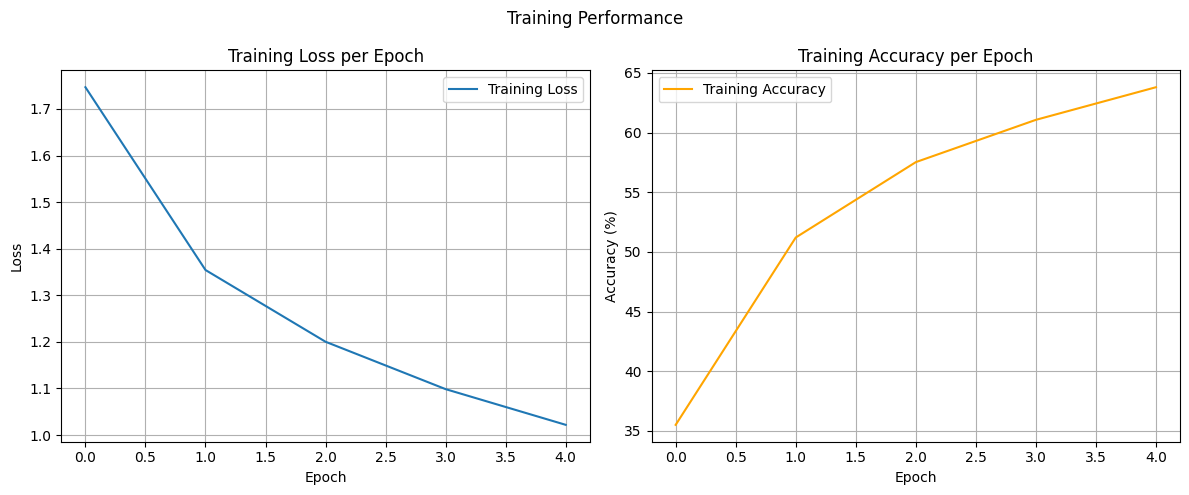

Visualization complete. Script finished.


In [ ]:
# This script demonstrates a simple end-to-end PyTorch workflow for a CNN.
# It is designed for teaching purposes, using a clear and well-commented approach.

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Select and load a simple dataset (CIFAR-10) ---
# CIFAR-10 is a good choice for teaching as it has 10 classes of small images.
# We'll apply some basic transformations to the data.

print("Loading and preparing the CIFAR-10 dataset...")

# Define the transformations to be applied to the images.
# ToTensor() converts images to PyTorch tensors.
# Normalize() standardizes the tensors.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training and test datasets.
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Create data loaders to handle batching and shuffling.
# Batch size is set to 4 to keep it small for demonstration.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Define the classes in the dataset.
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Dataset loaded successfully.")

# --- 2. Build a simple CNN model architecture step by step ---
# This is a basic CNN with two convolutional layers followed by three fully connected layers.

print("Building the SimpleCNN model...")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block: 3 input channels (for RGB images), 6 output channels, 5x5 kernel.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # Max pooling layer to down-sample the feature map.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional block: 6 input channels, 16 output channels, 5x5 kernel.
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Fully connected (dense) layers for classification.
        # The input size to the first linear layer is calculated based on the image size
        # after the two convolutional and pooling layers:
        # (32 - 5 + 1) / 2 = 14 -> (14 - 5 + 1) / 2 = 5
        # The output size is 5x5, and there are 16 channels, so 16 * 5 * 5 = 400.
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10) # 10 output classes for CIFAR-10.

    def forward(self, x):
        # Apply the first conv layer, followed by a ReLU activation and max pooling.
        x = self.pool(torch.relu(self.conv1(x)))
        # Apply the second conv layer, followed by a ReLU activation and max pooling.
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten the tensor for the fully connected layers.
        x = x.view(-1, 16 * 5 * 5)
        # Pass through the fully connected layers with ReLU activations.
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Final output layer without an activation function (for CrossEntropyLoss).
        x = self.fc3(x)
        return x

# Instantiate the model and set up the optimizer and loss function.
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define lists to store training history for visualization.
train_loss_history = []
train_accuracy_history = []

# --- 3. Train the model ---
# This is a simple training loop.
print("Starting training...")
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate over the training data batches.
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward pass: get predictions.
        outputs = model(inputs)

        # Calculate the loss.
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients.
        loss.backward()

        # Update model weights.
        optimizer.step()

        # Accumulate loss and accuracy metrics.
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch.
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_samples

    # Store history for visualization.
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Training finished.")

# --- 4. Evaluate the model ---
# Use the test set to evaluate the model's performance on unseen data.
print("Evaluating the model on the test set...")
correct_test = 0
total_test = 0
with torch.no_grad(): # Disable gradient calculation for evaluation.
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Accuracy of the network on the 10000 test images: {test_accuracy:.2f}%")

# --- 5. Visualize the training process ---
# Plot the loss and accuracy curves to show how the model learned over time.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Training Performance')

# Plotting Loss
ax1.plot(train_loss_history, label='Training Loss')
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting Accuracy
ax2.plot(train_accuracy_history, label='Training Accuracy', color='orange')
ax2.set_title('Training Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Visualization complete. Script finished.")
